In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
try:
    from torchvision import transforms, utils
except:
    !conda install --yes torchvision --no-channel-priority
    from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
try:
    from torchvision import transforms, utils
except:
    !pip install torchvision
    from torchvision import transforms, utils
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# You want to change these to be your own filenames
metadata_csv = 'damage_sample_metadata.csv'
label_csv = 'damage_sample_label.csv'

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [3]:
# read the tsv file with the labels
ladi_responses = pd.read_csv("http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_aggregated_responses_url.tsv",delimiter='\t',header='infer')
ladi_responses.head(1000)

,url,WorkerId,Answer
0,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:flood/water']
1,https://ladi.s3-us-west-2.amazonaws.com/Images...,1,['damage:flood/water']
2,https://ladi.s3-us-west-2.amazonaws.com/Images...,2,['damage:flood/water']
3,https://ladi.s3-us-west-2.amazonaws.com/Images...,20,['damage:flood/water']
4,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:flood/water']
5,https://ladi.s3-us-west-2.amazonaws.com/Images...,8,"['damage:flood/water', 'damage:washout']"
6,https://ladi.s3-us-west-2.amazonaws.com/Images...,9,"['damage:rubble', 'damage:flood/water']"
7,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:rubble']
8,https://ladi.s3-us-west-2.amazonaws.com/Images...,1,['damage:none']
9,https://ladi.s3-us-west-2.amazonaws.com/Images...,11,['damage:flood/water']


In [4]:
# Strip off bracket and comma from the Answer catagory
ladi_responses["Answer"] = ladi_responses["Answer"].str.strip('[|]')
# split list of responses into multiple rows
ladi_responses["Answer"] = ladi_responses["Answer"].str.split(",",expand = True)
# remove the single quote character from either end of string
ladi_responses["Answer"] = ladi_responses["Answer"].str.strip('\'')
# add a column to help with aggregation when pivoting
ladi_responses["response_count"] = 1
# Create a matrix with the number of workers who answered given label for given image
# using pivot table; filling in nan values with 0
label_matrix = ladi_responses.pivot_table(values='response_count', 
                                          index='url', 
                                          columns='Answer', 
                                          aggfunc='sum',
                                          fill_value=0)
label_matrix

Answer,damage:flood/water,damage:landslide,damage:misc,damage:none,damage:rubble,damage:smoke/fire,damage:washout,environment:dirt,environment:grass,environment:lava,environment:none,environment:rock,environment:sand,environment:shrubs,environment:snow/ice,environment:trees,infrastructure:bridge,infrastructure:building,infrastructure:communications-tower,infrastructure:dam-levee,infrastructure:none,infrastructure:pipe,infrastructure:railway,infrastructure:road,infrastructure:utility-line,infrastructure:water-tower,vehicle:aircraft,vehicle:boat,vehicle:car,vehicle:none,vehicle:truck,water:flooding,water:lake,water:none,water:ocean,water:puddle,water:river
url,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0020_e34a1edc-6d5c-472e-847e-89dac3ed4519.jpg,2,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0028_18dcd0d8-4b79-452e-9ade-604d4f13ddfd.jpg,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0035_add5632e-eec2-42a4-a7db-8c42871164c2.jpg,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0042_970b36fb-582b-4b51-a581-923efb394278.jpg,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20147/DSC_1575_787dc8f2-fb8f-4464-99a2-45ba5fc677c2.jpg,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3990_bdd98b00-d138-4daa-b842-4a4266cb2de9.jpg,0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3997_d3d2337b-b3e3-468c-8e2c-93ba34f9a219.jpg,1,0,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_4000_af3e8e76-fbba-4a6f-8aa7-44cd7c35fdaf.jpg,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# damage_matrix[damage_matrix['damage:washout'] > 0].shape[0]

# floodwater: 14K
# landslide: 800, remove
# misc: remove
# none: 34K
# rubble: 4K
# smoke/fire: 1.2K
# washout: 674, remove


In [5]:
# if none is greater than each of the other labels, keep none
# else, drop none

# if anything at end is > 0, that is a label.
labels = ['damage:flood/water', 'damage:rubble', 'damage:smoke/fire']
def proc(row):
    
    
    arr = [row[x] for x in labels]
    if row['damage:none'] > max(arr):
        for x in labels:
            row[x] = 0
        row['damage:none'] = 1
    else:
        row['damage:none'] = 0
        
        for x in labels:
            if row[x] > 0: row[x] = 1
            
    return row
        
    

damage_matrix = label_matrix[labels + ['damage:none']]
final_mat = damage_matrix.apply(proc, axis = 1)

In [29]:
final_mat

Answer,damage:flood/water,damage:rubble,damage:smoke/fire,damage:none
url,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0020_e34a1edc-6d5c-472e-847e-89dac3ed4519.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0028_18dcd0d8-4b79-452e-9ade-604d4f13ddfd.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0035_add5632e-eec2-42a4-a7db-8c42871164c2.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0042_970b36fb-582b-4b51-a581-923efb394278.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20147/DSC_1575_787dc8f2-fb8f-4464-99a2-45ba5fc677c2.jpg,1,0,0,0
...,...,...,...,...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3990_bdd98b00-d138-4daa-b842-4a4266cb2de9.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3997_d3d2337b-b3e3-468c-8e2c-93ba34f9a219.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_4000_af3e8e76-fbba-4a6f-8aa7-44cd7c35fdaf.jpg,0,0,0,1


In [6]:
sample_size=500
# none_sample = final_mat[final_mat['damage:none'] == 1].sample(sample_size)
# none_sample.shape

samples = final_mat[final_mat['damage:flood/water'] == 1].sample(sample_size)
for col in final_mat.columns[1:]:
#     print(col)
#     print(final_mat[final_mat[col] == 1].shape)
#     print(final_mat[final_mat[col] == 1].sample(sample_size))
    samples = samples.append(final_mat[final_mat[col] == 1].sample(sample_size))
#     print(samples)
samples = samples.reset_index().drop_duplicates(subset='url', keep='first').set_index('url')
# df = pd.DataFrame()
# for i, s in enumerate(samples):
#     df = df.merge(s, how='outer', left_index=True, right_index=True)
samples.shape

(1959, 4)

In [ ]:
samples.head(500)

In [ ]:
# Load ladi_images_metadata.csv
metadata = pd.read_csv('http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_images_metadata.csv')

# sampling
# sample_size=1000
# flood_sample = flood_examples.sample(sample_size)
# non_flood_sample = non_flood_examples.sample(sample_size)

# creating a df with True/False labels for flooding
# training_flood = pd.DataFrame(index=flood_sample.index, data={'label':True}).reset_index()
# training_non_flood = pd.DataFrame(index=non_flood_sample.index, data={'label':False}).reset_index()
# label_df = pd.concat([training_flood, training_non_flood], ignore_index=True)

samples.to_csv(label_csv)

# create list of urls to download
samples.reset_index()['url'].to_csv('urls_to_download.csv', index=False, header=False)

# # Get flood and non-flood metadata
damage_metadata = metadata[metadata['url'].isin(samples.index)]
# flood_metadata = metadata[metadata['url'].isin(flood_sample.index)]
# not_flood_metadata = metadata[metadata['url'].isin(non_flood_sample.index)]
# training_metadata = pd.concat([flood_metadata, not_flood_metadata], ignore_index=True)

damage_metadata.to_csv(metadata_csv)

In [ ]:
!mkdir -p training_images
!wget --content-disposition --trust-server-names -i urls_to_download.csv -P training_images/

In [6]:
scale = transforms.Resize(768)
crop = transforms.RandomCrop(512)
rotate = transforms.RandomRotation(20)
flip_demo = transforms.RandomHorizontalFlip(1) # flip with 100% chance just to demo
flip = transforms.RandomHorizontalFlip(p=0.5)
composed = transforms.Compose([scale,
                               crop,
                               rotate,
                               flip_demo])

In [7]:
# convenient function for showing the images
def show_image(image):
    plt.imshow(image)
    # pause a bit so that plots are updated
    plt.pause(0.01)

def convert_url_to_local_path(url):
    '''
    gets the location of the downloaded image
    '''
    return 'training_images/'+url.split('/')[-1]

class DamageSampleDataset(Dataset):

    def __init__(self, metadata_csv, label_csv, transform = None):
        """
        Args:
            metadata_csv (string): Path to the csv file with metadata.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.damage_sample_metadata = pd.read_csv(metadata_csv)
        # get the path in the shared directory
        self.damage_sample_metadata['local_path'] = self.damage_sample_metadata['url'].apply(convert_url_to_local_path)
        self.damage_sample_label = pd.read_csv(label_csv)
        self.damage_sample_data = pd.merge(self.damage_sample_metadata, 
                                        self.damage_sample_label,
                                       on="url")
        self.transform = transform
        
    def __len__(self):
        return len(self.damage_sample_metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## Load images from local directory. There is no need to redownload images to local machine. ##
        local_path = self.damage_sample_metadata.iloc[idx]['local_path']
        url = self.damage_sample_metadata.iloc[idx]['url']
        try:
            image = Image.fromarray(io.imread(local_path))
            img_name = local_path
        except:
            image = Image.fromarray(io.imread(url))
            img_name = url
        uuid = self.damage_sample_data.iloc[idx, 1]
        timestamp = self.damage_sample_data.iloc[idx, 2]
        gps_lat = self.damage_sample_data.iloc[idx, 3]
        gps_lon = self.damage_sample_data.iloc[idx, 4]
        gps_alt = self.damage_sample_data.iloc[idx, 5]
        file_size = self.damage_sample_data.iloc[idx, 6]
        width = self.damage_sample_data.iloc[idx, 7]
        height = self.damage_sample_data.iloc[idx, 8]
        label = torch.tensor(self.damage_sample_data.iloc[idx, -4:].tolist())
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 
                  'image_name': img_name, 
                  'damage_labels': label, 
                  'uuid': uuid, 
                  'timestamp': timestamp, 
                  'gps_lat': gps_lat, 
                  'gps_lon': gps_lon, 
                  'gps_alt': gps_alt, 
                  'orig_file_size': file_size, 
                  'orig_width': width, 
                  'orig_height': height}

        return sample
    def __str__(self):
        return self.damage_sample_data.to_string()
    def dataset(self):
        return self.damage_sample_data
    def dataset_type(self):
        return type(self.damage_sample_data)
    def get_columns(self):
        return self.damage_sample_data.columns
    def get_labels(self):
        return torch.tensor(self.damage_sample_data.iloc[:, -4:].values)

In [ ]:
# damage_sample_dataset = DamageSampleDataset(metadata_csv = metadata_csv, label_csv = label_csv, transform = transforms.ToTensor())

In [8]:
transformed_dataset = DamageSampleDataset(metadata_csv = metadata_csv, 
                                       label_csv = label_csv, 
                                       transform = transforms.Compose([scale, 
                                                                       crop, 
#                                                                        rotate, 
#                                                                        flip, 
                                                                       transforms.ToTensor()]
                                                                     )
                                      )

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

batch_size = 16
test_split_ratio = .1
shuffle_dataset = True
random_seed = 42
# num_workers = 1

# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split_ratio * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                                sampler=test_sampler)

In [10]:
import torch.nn as nn
import torch.nn.functional as F
try:
    from cnn_finetune import make_model
except:
    !pip install cnn-finetune
    from cnn_finetune import make_model

In [11]:
net = make_model('resnet50', num_classes=4, pretrained=True).cuda()

In [17]:
print(net)

ResNetWrapper(
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [12]:
def pos_weights(labels):
    pos = labels.sum(axis=0)
    neg = torch.ones(labels.shape[-1])*labels.shape[0] - pos
    return (neg / pos).cuda()
print(pos_weights(transformed_dataset.get_labels()))

tensor([1.6496, 2.1659, 2.9085, 2.9320], device='cuda:0')


In [13]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights(transformed_dataset.get_labels()))
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [14]:
def get_checkpoint_path(epoch):
    return f'epoch_checkpoints_resnet50_weighted/checkpoint_epoch{epoch}.pth'

In [ ]:
torch.backends.cudnn.benchmark = True # flag for some GPU optimizations
starting_epoch = 10
additional_epochs = 20
if starting_epoch > 1:
    net.load_state_dict(torch.load(get_checkpoint_path(starting_epoch-1)))
for epoch in range(starting_epoch, starting_epoch+additional_epochs):  # loop over the dataset multiple times
    running_loss, running_acc = 0.0, torch.tensor([0.0, 0.0, 0.0, 0.0]).cuda()
    for i, data in enumerate(train_loader, 0):
#         net.train()
        # get the inputs; data is a list of [inputs, labels]
#         print(data['image'].shape)
#         print(data['damage_labels'])
#         print(data['damage_labels'].shape)
        inputs = data['image'].cuda()
        labels = data['damage_labels'].cuda()
        
        # casting int to long for loss calculation#
        labels = labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(torch.sigmoid(outputs))
#         print(labels)
#         outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        pred = (torch.sigmoid(outputs) > 0.5).float()
        correct = (pred == labels).float().sum(axis=0)
        running_acc += correct
        print_freq = 10
        if (i+1) % print_freq == 0:  
#             print(torch.sigmoid(outputs))
#             print(labels)
            print(f'[Epoch {epoch}/{epoch+additional_epochs}, Batch {i+1}]    Loss: {running_loss/print_freq}    Binary Accuracies: {running_acc/(len(labels)*print_freq)}    Combined Accuracy: {(running_acc/(len(labels)*print_freq)).mean()}')
            running_loss, running_acc = 0.0, torch.tensor([0.0, 0.0, 0.0, 0.0]).cuda()
    # save the model
    PATH = get_checkpoint_path(epoch)
    torch.save(net.state_dict(), PATH)
print('Finished Training')

In [ ]:
fig, ax = plt.subplots(1)
plt.imshow(data['image'][0].permute(1, 2, 0))

In [ ]:
torch.set_printoptions(edgeitems=100)
print(data['image'][0])

In [ ]:
torch.cuda.memory_allocated()

In [16]:
net.load_state_dict(torch.load(get_checkpoint_path(18)))

<All keys matched successfully>

In [40]:
correct = torch.zeros(4).cuda()
total = 0
truth_labels = []
predicted_labels = []
with torch.no_grad():
    for data in test_loader:
        images = data['image'].cuda()
        labels = data['damage_labels'].cuda()
        outputs = net(images)
#         pred = (torch.sigmoid(outputs) > 0.5).float()
        pred = torch.hstack((torch.sigmoid(outputs[:,0:1]) > 0.5, torch.sigmoid(outputs[:,1:]) > 0.4)).float()
        correct += (pred == labels).float().sum(axis=0)
        total += labels.size(0)
        truth_labels.append(labels.cpu())
        predicted_labels.append(pred.cpu())

In [66]:
net(transformed_dataset[0]['image'][np.newaxis, :].cuda())

tensor([[-0.0747, -0.2819, -0.4280, -1.5597]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [43]:
truth_labels = np.vstack([x.numpy() for x in truth_labels])
predicted_labels = np.vstack([x.numpy() for x in predicted_labels])

In [44]:
print('Binary Accuracies:', (correct / total).tolist())
print('FINAL ACCURACY: {:.2%}'.format((correct / total).mean()))

Binary Accuracies: [0.8265305757522583, 0.7091836333274841, 0.75, 0.7551020383834839]
FINAL ACCURACY: 76.02%


In [45]:
import sklearn.metrics
confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(truth_labels, predicted_labels)
confusion_matrix
# disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, ['flood','no flood'])
# disp.plot()

array([[[105,  21],
        [ 13,  57]],

       [[ 95,  41],
        [ 16,  44]],

       [[106,  34],
        [ 15,  41]],

       [[115,  31],
        [ 17,  33]]])

In [22]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white"})

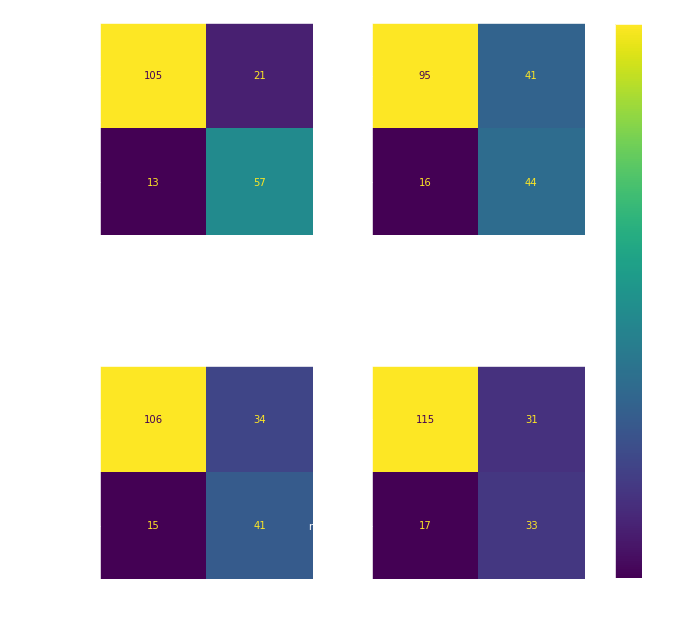

In [46]:
class_names = ['flood/water','rubble','smoke/fire','no damage']
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
for i in range(4):
    if i < 3:
        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix[i], ['no ' + class_names[i], class_names[i]])
    else:
        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix[i], ['damage', 'no damage'])
    disp.plot(ax=ax[i])
    disp.ax_.set_title(class_names[i])
    if i<2:
        disp.ax_.set_xlabel('')
    if i%2!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.5, hspace=0)

plt.tight_layout()
plt.colorbar(disp.im_, ax=ax, shrink=0.8)

plt.show()
fig.savefig('confusionmatrix18adj1.png', transparent=True)

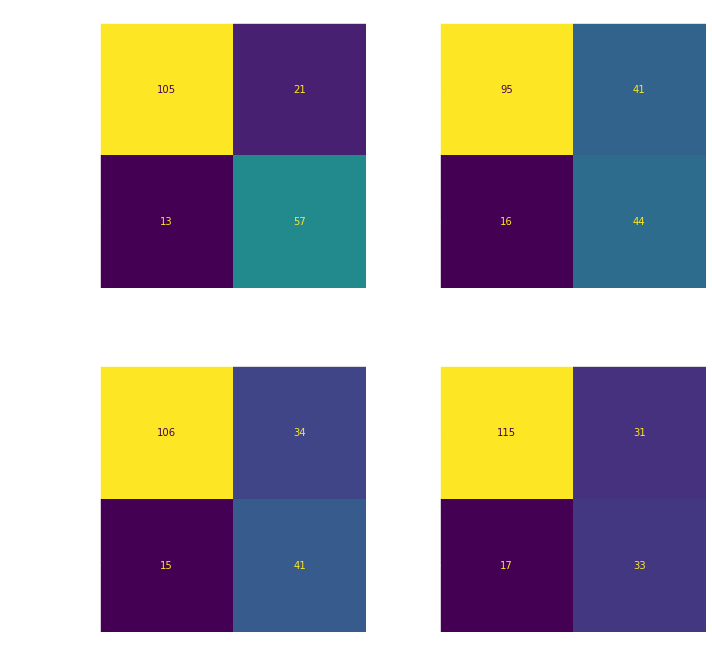

In [47]:
class_names = ['flood/water','rubble','smoke/fire','no damage']
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
for i in range(4):
    if i < 3:
        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix[i], ['no ' + class_names[i], class_names[i]])
    else:
        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix[i], ['damage', 'no damage'])
    disp.plot(ax=ax[i])
    disp.ax_.set_title(class_names[i])
    if i<2:
        disp.ax_.set_xlabel('')
    if i%2!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.5, hspace=0)
# plt.style.use("dark_background")
plt.tight_layout()
# plt.colorbar(disp.im_, ax=ax, shrink=0.8)

plt.show()
fig.savefig('confusionmatrix18adj1nobar.png', transparent=True)

In [51]:
# plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
idx = 5 
transformed_dataset[idx]['image'] # __getitem__ -> []
out  = net(transformed_dataset[idx]['image'][np.newaxis, :].cuda()) # adds axis on beginning of shape, then sends to cuda
pred = (torch.sigmoid(out) > 0.5).float()
pred == transformed_dataset[idx]['damage_labels'].cuda()

In [ ]:
torch.sigmoid(out)

In [ ]:
transformed_dataset[idx]['damage_labels']

In [ ]:
transformed_dataset[idx]['image_name']

In [133]:
def filt(row):
    if ('A0067AP-_64b3abbf-1cc0-422b-9f82-26b55b1fa03e.jpg' in row): print(row)
#     return '17f5c49e2f4e' in row
    

test_mat = final_mat.reset_index()
test_mat['url'].apply(filt)


https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9075/614024/A0067AP-_64b3abbf-1cc0-422b-9f82-26b55b1fa03e.jpg


0        None
1        None
2        None
3        None
4        None
         ... 
40192    None
40193    None
40194    None
40195    None
40196    None
Name: url, Length: 40197, dtype: object